In [21]:
from src.dataset import MyoblastDataset
from src.utils import create_transforms
from monai.data import ThreadDataLoader
import ttach as tta
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from monai.networks.nets import EfficientNetBN
from monai.inferers import sliding_window_inference
from tqdm.notebook import tqdm
from src.model_trainer import Wrapper, sliding_window_inferencer
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [22]:
EXPERIMENT="cancer_multiclass"
EPOCH=210
EXP_IDS = [220429, 220506]
LOG_DIR = f"{EXPERIMENT}_{EPOCH}"
SAVE_PATH = f"experiments/{EXPERIMENT}/models_{EXP_IDS}"
MODEL = torch.load(f"{SAVE_PATH}/best_loss.pth")["model"]
NUM_CLASSES=5

train_transforms, val_transforms, test_transforms = create_transforms()
test_dataset = MyoblastDataset(cell_type="cancer", exp_ids=[220508], mode="cropped", transform=val_transforms)
#test_dataset = MyoblastDataset(cell_type="fibroblast", exp_ids=[240221], mode="test", transform=test_transforms)
test_loader = ThreadDataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=False)

In [23]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

test_loss_fn = torch.nn.CrossEntropyLoss()
eval_model = EfficientNetBN("efficientnet-b5", pretrained=False, progress=False, spatial_dims=2, in_channels=1, num_classes=NUM_CLASSES)
#eval_model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=NUM_CLASSES, pretrained=False)
eval_model.load_state_dict(MODEL)
eval_model.to("cuda")
eval_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    loss = 0
    for test_data in tqdm(test_loader):
        test_images, test_labels = (
            test_data["image"].to("cuda"),
            test_data["label"].to("cuda"),
        )
        labels = []
        with torch.cuda.amp.autocast():
            # for transformer in transforms: # custom transforms or e.g. tta.aliases.d4_transform() 
        
            # augment image
            #test_images = transformer.augment_image(test_images)
            pred = eval_model(test_images)
            #y_pred_out = sliding_window_inference(test_images, roi_size=(512, 512), sw_batch_size=8, predictor=Wrapper(eval_model, NUM_CLASSES), overlap=0.75)
            #pred = sliding_window_inferencer(test_images, eval_model, patch_size=(512, 512), overlap=0.8, num_classes=NUM_CLASSES)
            #print(pred)
            #pred = torch.mean(y_pred_out, dim=(2, 3))
            
            labels.append(pred)
        
        concatenated_tensor = torch.cat(labels, dim=0)
        pred = torch.mean(concatenated_tensor,dim=0).unsqueeze(0)
        loss_batch = test_loss_fn(pred, test_labels) 
        loss += loss_batch.item()
        
        pred = pred.argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
    loss = loss / len(test_loader)

torch.cuda.empty_cache()

  0%|          | 0/798 [00:00<?, ?it/s]

In [24]:
loss

0.8585011369004883

              precision    recall  f1-score   support

           0     0.6939    0.8718    0.7727       156
           1     0.9500    0.5655    0.7090       168
           2     0.5911    0.8690    0.7036       168
           3     0.5164    0.3750    0.4345       168
           4     0.9774    0.9420    0.9594       138

    accuracy                         0.7143       798
   macro avg     0.7458    0.7247    0.7158       798
weighted avg     0.7378    0.7143    0.7058       798



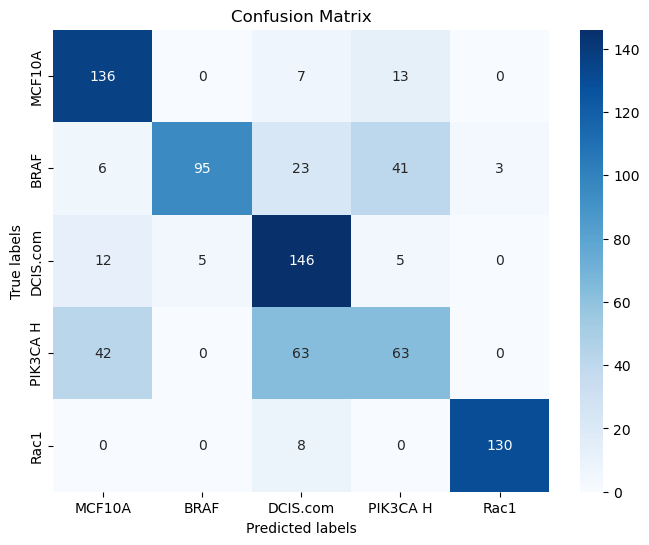

In [25]:
cm = confusion_matrix(y_true, y_pred)
REPORT_SAVE_PATH = f"experiments/{EXPERIMENT}/models/"
# Extract labels from classification report
report = classification_report(y_true, y_pred, digits=4, zero_division=0)
print(report)


#labels = ['WT', 'K32', 'L380S', 'R249W', 'Nesprin1KO']
labels = ['MCF10A', 'BRAF', 'DCIS.com', 'PIK3CA H', 'Rac1']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.savefig(REPORT_SAVE_PATH + "confusion_matrix_multiclass.png", bbox_inches='tight')
plt.show()
# with open(REPORT_SAVE_PATH + "classification_report.txt", "w") as f:
#     f.write(report)

  0%|          | 0/2 [00:00<?, ?it/s]

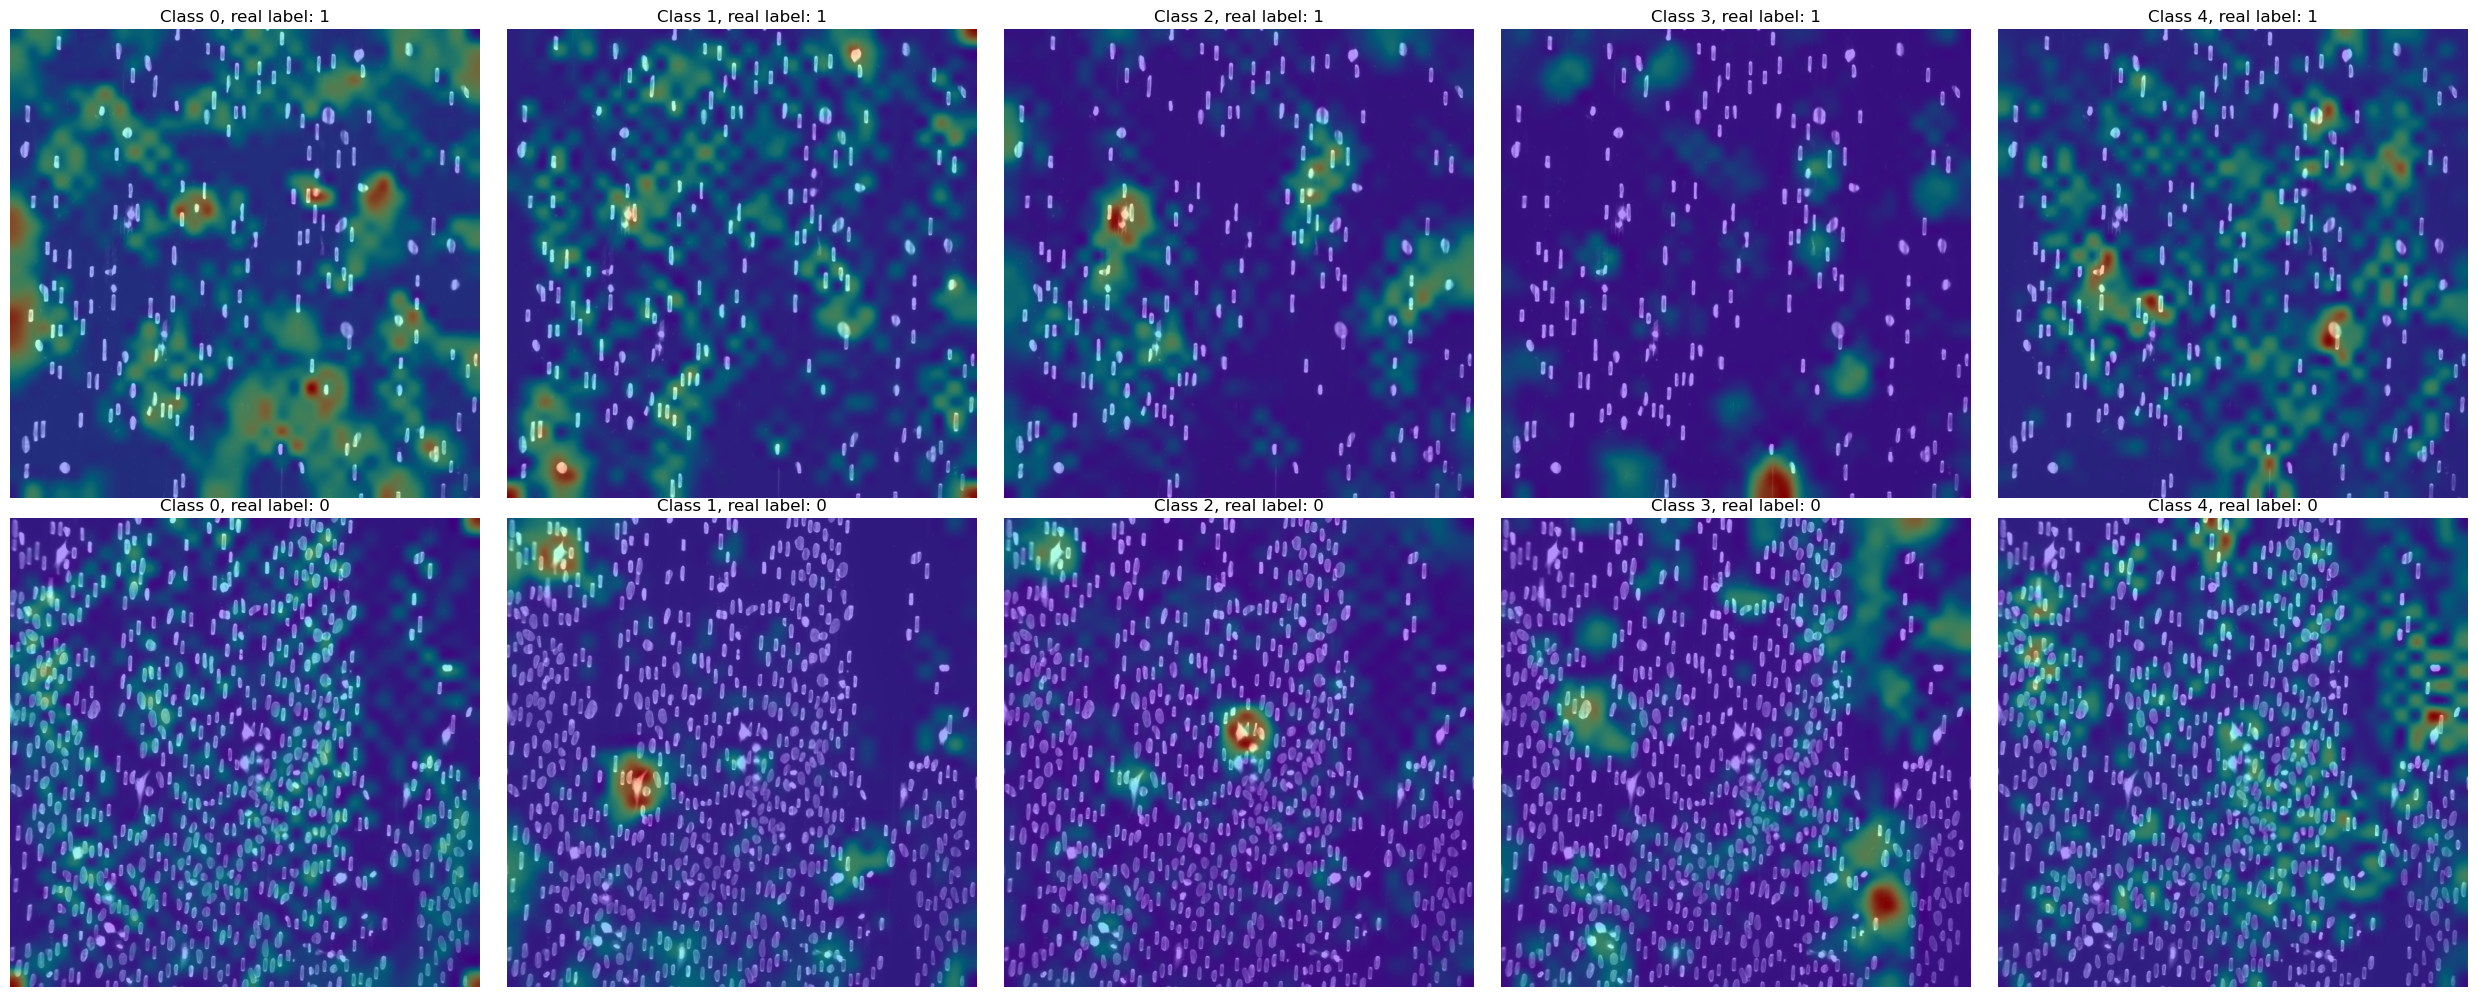

In [7]:
from monai.visualize import GradCAMpp, GradCAM
from monai.visualize.class_activation_maps import default_normalizer
from PIL import Image
eval_model = EfficientNetBN("efficientnet-b7", pretrained=False, progress=False, spatial_dims=2, in_channels=1, num_classes=NUM_CLASSES)
#eval_model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=NUM_CLASSES, pretrained=False)
eval_model.load_state_dict(MODEL)
#cam = GradCAMpp(nn_module=eval_model, target_layers="_conv_head")
cam = GradCAM(nn_module=eval_model, target_layers="_conv_head")

NUM_SAMPLES=2
fig, axes = plt.subplots(NUM_SAMPLES, NUM_CLASSES, figsize=(5 * NUM_CLASSES, 5 * NUM_SAMPLES))

for j in tqdm(range(NUM_SAMPLES)):
    
    input = test_dataset[12 * j]
    input_image = input["image"]
    
    for i in range(NUM_CLASSES):
        result = cam.compute_map(x=input_image.unsqueeze(0), class_idx=i).detach().numpy()
        activation_map_resized = np.array(Image.fromarray(result[0][0]).resize(input_image.shape[1:][::-1]))
        activation_map_normalized = activation_map_resized / np.max(activation_map_resized)
    
        axes[j, i].imshow(input_image[0], cmap='gray')
        axes[j, i].imshow(activation_map_normalized, cmap='rainbow', alpha=0.5)
        axes[j, i].set_title(f'Class {i}, real label: {input["label"]}')
        axes[j, i].axis('off')

plt.tight_layout()
plt.show()